# GED PRE and POST ANALYSIS

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl


# Set display options to avoid line breaks
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.width', 1000)        # Set a large display width
pd.set_option('display.colheader_justify', 'center')  # Center headers
pd.set_option('display.max_colwidth', None) # No limit on column width
# Adjust display options
pd.set_option('display.max_colwidth', None)  # Set max column width to None
pd.set_option('display.width', None)          # Use the full width of the output area
pd.set_option('display.expand_frame_repr', False)  # Prevent DataFrame from being split across lines


# Write necessary functions 

In [3]:
# read files and convert it to dataframes
# loop over the file list and save the dataframes into dataframes dictionary for easily access
def convert_to_df(file_info_paths):
    dataframes = {}
    # Loop through the file information
    for file_path, encoding, df_name in file_info_paths:
        try:
            df = pd.read_csv(file_path, encoding=encoding)  # Read the CSV with the specified encoding
            dataframes[df_name] = df             # Store the DataFrame with the specified name
        except Exception as e:
            print(f"Error reading {file_path}: {e}")  # Handle any exceptions
    return dataframes

In [4]:
#different subjects has different max score, in order to do fair comparison, we normalize to 10-point scale
def normalize_to_10(score, max_score):
    # Normalize the score to a 10-point scale.
    return (score / max_score) * 10

In [5]:
def normalize_scores(df):
    # Iterate through DataFrame columns
    for col in df.columns:
        #use pd.api.types.is_numeric_dtype to check numeric data type like int ,float
        if not col.startswith('Grade/10.00') and pd.api.types.is_numeric_dtype(df[col]) and 'Grade' in col:  # Normalize scores for columns that is not 10-point scale
            # Determine the max_score and subject name based on column name
            sub_name = col.split('_')[1]
            if '50.00' in col:
                max_score = 50
            elif '100.00' in col:
                max_score = 100
            elif '200.00' in col:
                max_score = 200
            else:
                continue  # Skip if max_score is not defined
            
            # Normalize and create new column name
            df[f'n_{sub_name}_{col.split("_")[-1]}'] = df[col].apply(lambda x: normalize_to_10(x, max_score))
            
#             # Selecting columns that start with 'Grade' to calcluate mean score
#             grade_columns = [col for col in merged_scores.columns if 'test' in col:]
#             df[f'avg_{sub_name}'] = df[grade_columns]
#             merged_scores[f'avg_{subject_name}'] = merged_scores[grade_columns].mean(axis=1)

    return df


In [6]:
#functions to read subject exam scores from google sheeets
def read_and_merge_scores(score_info,keep_columns, merge_suffixes=None, grade_column_mapping=None):
    """
    Reads data from Google Sheets and merges DataFrames based on email address.

    Parameters:
        score_info (list): List of tuples containing (URL, encoding, name).
        merge_suffixes (list): List of suffixes for merging.
        grade_column_mapping (dict): Mapping for renaming grade columns.

    Returns:
        DataFrame: Merged DataFrame of scores.
    """
    dataframes = convert_to_df(file_info_paths=score_info)

    # Extract DataFrames from the dictionary
    # will get the list of the dataframes
    tests = [dataframes[name] for _, _, name in score_info]

    # Merge DataFrames
    merged_scores = tests[0]  # grab the first dataframe to be merged on

    # Iterate over the test DataFrames starting from the second one (index 1)
    for i, test in enumerate(tests[1:], start=1):
        suffix = merge_suffixes[i]  # Get the corresponding suffix for the current test
        merged_scores = merged_scores.merge(test, on='Email address', how='outer', suffixes=('', f'_{suffix}'))

    merged_scores = merged_scores[keep_columns].drop_duplicates()

    # duplicated_scores = merged_scores[merged_scores['Email address'].duplicated(keep=False)]
    # print(f"Duplicated scores:\n{duplicated_scores.head()}")

    # Select relevant columns and drop duplicates
    if grade_column_mapping:
        merged_scores = merged_scores.rename(columns=grade_column_mapping)

    # Take max score for each duplicated entry
    merged_scores = merged_scores.groupby('Email address', as_index=False).max()
    
    # merge data to get student ID column for each subject
    df = convert_to_df([('https://docs.google.com/spreadsheets/d/1tXg8YSSB2ASpmvWmuEv77yn1_EaxpLtR/gviz/tq?tqx=out:csv','utf-8','id_df')])
    id_df = df['id_df']
    merged_scores = merged_scores.merge(id_df, on = 'Email address', how='left') 
    
    #add batch column
    merged_scores['Batch'] = 2
#     # Selecting columns that start with 'Grade' to calcluate mean score
#     grade_columns = [col for col in merged_scores.columns if col.startswith('Grade')]
#     # Calculating average score and assigning to a new column 'avg_math'
#     subject_name = score_info[0][2].split('_')[0] #Extract subject name from score info

#     merged_scores[f'avg_{subject_name}'] = merged_scores[grade_columns].mean(axis=1)
    
    
    return merged_scores

# Start reading all the necessary files from different sources

In [7]:
# Define score info for each subject
sci_score_info = [
    ('https://docs.google.com/spreadsheets/d/1cOa5iDXSkWRgaKw6O-SdPw9MmrcbyS-UkojhRMlEglc/gviz/tq?tqx=out:csv', 'utf-8', 'sci_test1'),
    ('https://docs.google.com/spreadsheets/d/1jffdahQgJZ1DV3qCZVIkOox0D6yRKPNszX43348gRPk/gviz/tq?tqx=out:csv', 'utf-8', 'sci_test2'),
    ('https://docs.google.com/spreadsheets/d/1PZ0a-s0Bmq6aOEAixiSmLRXwcXj389Z1SFwi7k2Ev4s/gviz/tq?tqx=out:csv', 'utf-8', 'sci_test3'),
    ('https://docs.google.com/spreadsheets/d/1J7FKxCIaFkDKR9dLdJFHQIcdtJO_aL5JCvlA4I9B8TE/gviz/tq?tqx=out:csv', 'utf-8', 'sci_test4')
]

math_score_info = [
    ('https://docs.google.com/spreadsheets/d/1RE6CnF-EwP-F3xpoyPpOEVXMLIa4HiCQE515HMXG_8s/gviz/tq?tqx=out:csv', 'utf-8', 'math_test1'),
    ('https://docs.google.com/spreadsheets/d/1yQuhwCGD5zMESM6L2SWmjcZ_w48T7ttsKncUxFpAgf0/gviz/tq?tqx=out:csv', 'utf-8', 'math_test2'),
    ('https://docs.google.com/spreadsheets/d/1NH0PNH0x576UYubhqWeDC9OPT4RbgRDwV1iSQL9i2P8/gviz/tq?tqx=out:csv', 'utf-8', 'math_test3'),
    ('https://docs.google.com/spreadsheets/d/1YH0PnqC8UK5Ebwczi0J7k8LU8HmE_o3MV7LNXJHdVp8/gviz/tq?tqx=out:csv', 'utf-8', 'math_test6')
]

ss_score_info = [
    ('https://docs.google.com/spreadsheets/d/1J862tfmyLEdwUM3Tj6E4C_Fz6k-TGuyuChhCvLg4pHE/gviz/tq?tqx=out:csv', 'utf-8', 'ss_test1'),
    ('https://docs.google.com/spreadsheets/d/1ywFsO8QhuQ3WXZY_VupVzWVfvaF9MOvMn3Y1vzRTtD4/gviz/tq?tqx=out:csv', 'utf-8', 'ss_test2'),
    ('https://docs.google.com/spreadsheets/d/1x3vXQLBclk4ledzng_YI9277YTaDdlhV3ROZM91d8SI/gviz/tq?tqx=out:csv', 'utf-8', 'ss_test3'),
]

rla_score_info = [
    ('https://docs.google.com/spreadsheets/d/1NsosKJex878HwPu4-WWwGIE29RLaVF7tLkTUCs6xS-4/gviz/tq?tqx=out:csv', 'utf-8', 'rla_test1'),
    ('https://docs.google.com/spreadsheets/d/1VCp415quLaT9AW1U1U6uzWDhvpULVihl-vkxwnWjvm0/gviz/tq?tqx=out:csv', 'utf-8', 'rla_test2'),
    ('https://docs.google.com/spreadsheets/d/1GwAoN3k_A9e0OdXTU_L3OvUOikGNONAtmWR2q8ApZAA/gviz/tq?tqx=out:csv', 'utf-8', 'rla_test3'),
]


# Define the merge suffixes for each subject
sci_merge_suffixes = ['', 'sci_test2', 'sci_test3', 'sci_test4']
math_merge_suffixes = ['', '', 'math_test3', 'math_test6']
ss_merge_suffixes = ['', 'ss_test2', '']
rla_merge_suffixes = ['', 'rla_test2', 'rla_test3']

# only major columns will be kept, to subset the dataframes from multiple columns
sci_columns = ['Email address', 'Grade/10.00', 'Grade/10.00_sci_test2', 'Grade/10.00_sci_test3', 'Grade/10.00_sci_test4']
math_columns = ['Email address', 'Grade/50.00', 'Grade/10.00', 'Grade/10.00_math_test3', 'Grade/10.00_math_test6']
ss_columns = ['Email address', 'Grade/100.00', 'Grade/100.00_ss_test2', 'Grade/200.00']
rla_columns = ['Email address', 'Grade/10.00', 'Grade/10.00_rla_test2', 'Grade/10.00_rla_test3']


# Define the grade column mappings for each subject
sci_grade_mapping = {
    'Grade/10.00': 'Grade/10.00_sci_test1',
    'Grade/10.00_sci_test2': 'Grade/10.00_sci_test2',
    'Grade/10.00_sci_test3': 'Grade/10.00_sci_test3',
    'Grade/10.00_sci_test4': 'Grade/10.00_sci_test4'
}

math_grade_mapping = {
    'Grade/50.00': 'Grade/50.00_math_test1',
    'Grade/10.00': 'Grade/10.00_math_test2',
    'Grade/10.00_math_test3': 'Grade/10.00_math_test3',
    'Grade/10.00_math_test6': 'Grade/10.00_math_test6'
}

ss_grade_mapping = {
    'Grade/100.00': 'Grade/100.00_ss_test1',
    'Grade/100.00_ss_test2': 'Grade/100.00_ss_test2',
    'Grade/200.00': 'Grade/200.00_ss_test3'
}

rla_grade_mapping = {
    'Grade/10.00': 'Grade/10.00_rla_test1',
    'Grade/10.00_rla_test2': 'Grade/10.00_rla_test2',
    #'Grade/10.00_rla_test3': 'Grade/10.00_rla_test3'
}

# Read and process scores for each subject
sci_scores = read_and_merge_scores(sci_score_info,keep_columns=sci_columns, merge_suffixes=sci_merge_suffixes, grade_column_mapping=sci_grade_mapping)
math_scores = read_and_merge_scores(math_score_info,keep_columns=math_columns, merge_suffixes=math_merge_suffixes, grade_column_mapping=math_grade_mapping)
ss_scores = read_and_merge_scores(ss_score_info,keep_columns=ss_columns, merge_suffixes=ss_merge_suffixes, grade_column_mapping=ss_grade_mapping)
rla_scores = read_and_merge_scores(rla_score_info,keep_columns=rla_columns, merge_suffixes=rla_merge_suffixes, grade_column_mapping=rla_grade_mapping)
#rla_scores = rla_scores.drop(columns='Grade/10.00_rla_test3') # drop it since all values 
# Display the results
#print(sci_scores.head())
# print(math_scores.head())
# print(ss_scores.head())
print(rla_scores.head())

         Email address         Grade/10.00_rla_test1  Grade/10.00_rla_test2 Grade/10.00_rla_test3   Student ID    Batch
0        chaintmyat@gmail.com          6.11                    NaN                         NaN     GED202402_104    2  
1     eaintchittcho@gmail.com          4.44                    NaN                         NaN      GED202402_94    2  
2     ehtharshee710@gmail.com          8.33                   6.21              Not yet graded      GED202402_67    2  
3           ei49137@gmail.com          8.33                   9.31              Not yet graded      GED202402_09    2  
4  eithandarkyaw611@gmail.com           NaN                   7.59                         NaN      GED202402_92    2  


In [8]:
# normalize to 10-point scale 
math_scores = normalize_scores(math_scores)
sci_scores = normalize_scores(sci_scores)
ss_scores = normalize_scores(ss_scores)
rla_scores = normalize_scores(rla_scores)


# create average score column for each subject, axis=1 row by row
math_scores['avg_math'] = math_scores[['n_math_test1','Grade/10.00_math_test2','Grade/10.00_math_test3','Grade/10.00_math_test6']].mean(axis=1)
sci_scores['avg_sci'] = sci_scores[['Grade/10.00_sci_test1','Grade/10.00_sci_test2','Grade/10.00_sci_test3','Grade/10.00_sci_test4']].mean(axis=1)
#rla_scores['avg_rla'] =rla_scores[['Grade/10.00_rla_test1','Grade/10.00_rla_test2','Grade/10.00_rla_test3']].mean(axis=1)
rla_scores['avg_rla'] =rla_scores[['Grade/10.00_rla_test1','Grade/10.00_rla_test2','Grade/10.00_rla_test3']].apply(pd.to_numeric, errors='coerce').mean(axis=1) #There is an error 
ss_scores['avg_ss'] =ss_scores[['n_ss_test1','n_ss_test2','n_ss_test3']].mean(axis=1)

#drop non normalized extra columns for each subject
math_scores.drop(columns=['Grade/50.00_math_test1'],inplace=True)
ss_scores.drop(columns=['Grade/100.00_ss_test1','Grade/100.00_ss_test2','Grade/200.00_ss_test3'],inplace=True)

print(math_scores.columns)
print(ss_scores.columns)

Index(['Email address', 'Grade/10.00_math_test2', 'Grade/10.00_math_test3',
       'Grade/10.00_math_test6', 'Student ID', 'Batch', 'n_math_test1',
       'avg_math'],
      dtype='object')
Index(['Email address', 'Student ID', 'Batch', 'n_ss_test1', 'n_ss_test2',
       'n_ss_test3', 'avg_ss'],
      dtype='object')


In [9]:
# get batch 1 score info for 3 students, we only able to extract 3 students for now due to some LMS issue 
b1_scores_info = [
    ('https://docs.google.com/spreadsheets/d/1LUKLmvO7MRJ53ez53l332WeYQN0U-uUNQPRl08UUXyU/gviz/tq?tqx=out:csv','utf-8','b1_scores')
]
dataframes = convert_to_df(file_info_paths=b1_scores_info)
b1_scores = dataframes['b1_scores']

# filter only necessary columns for each subjects
b1_sci_scores = b1_scores[['Email address',	'Student ID',	'Batch',	'sci_test1',	'sci_test2',	'sci_test3',	'sci_test4',	'sci_test5',	'sci_test6',	'sci_test7',	'sci_test8']]
b1_rla_scores = b1_scores[['Email address',	'Student ID',	'Batch','rla_test1','rla_test2','rla_test3','rla_test4']]
b1_math_scores = b1_scores[['Email address','Student ID',	'Batch','math_test1','math_test2','math_test3','math_test4','math_test5']]
b1_ss_scores=b1_scores[['Email address',	'Student ID',	'Batch','ss_final']]
b1_ss_scores.head()

,Email address,Student ID,Batch,ss_final
0,cottonphyo01@gmail.com,GED2024003,1,186.36
1,khattgarpun1997@gmail.com,GED2024017,1,167.28
2,ayemonyadanar.aung2006@gmail.com,GED2024007,1,172.73


In [10]:
# reading class participation survery from teachers and save it to student_ptc_info
student_ptc_info=[
    ('https://docs.google.com/spreadsheets/d/1EpHVOPgLW3x9hgHCoZ9qOP3fR8BHM1Nny1I9SowixUQ/gviz/tq?tqx=out:csv','utf-8','studen_ptc_info')
]
dataframes = convert_to_df(file_info_paths=student_ptc_info)
studen_ptc_info=dataframes['studen_ptc_info']
#print(studen_ptc_info.head())
#check type of the result
#print(type(student_ptc_info))

#change to dataframe
student_ptc_info_df = pd.DataFrame(studen_ptc_info)
#print(type(student_ptc_info_df))

#remove unnessary columns since it contains a lot of Empty Unnamed columns
student_ptc_info_df = student_ptc_info_df.loc[:,~student_ptc_info_df.columns.str.contains('^Unnamed')]
#print(student_ptc_info_df.head())

In [11]:
# read survery data from students and save to pj2_survey_df
survey_response_path =[
    ('https://docs.google.com/spreadsheets/d/1jXqz4q4_QZBxvS_A3N_HFwySnDrLiLOxdlbvzd-ERsc/gviz/tq?tqx=out:csv','utf-8','survery_df')
]
dataframes = convert_to_df(file_info_paths=survey_response_path)
survey_df = dataframes['survery_df']
pj2_col_start = 'On a scale of 1-5, how would you rate your confidence in the following subjects before joining the GED program? ( 1 means no confidence and 5 means very confident )  [Math]'
pj2_col_end = 'Which aspects of the GED program do you believe contributed the most to your improvement? (Select up to 3 options)'
pj2_survey_df = survey_df.loc[:, pj2_col_start:pj2_col_end]
pj2_survey_df['Student ID'] = survey_df['GED ID Number']
# convert batch number from text to string and make new columns
pj2_survey_df['Batch'] = survey_df['Batch'].apply(lambda x:1 if x == 'GED First Batch' else 2)
#pj2_survey_df.columns

In [12]:
# rename suvery columns to make it more readable and convert to long format for data analysis
pj2_survey_df.rename(columns={
   'On a scale of 1-5, how would you rate your confidence in the following subjects before joining the GED program? ( 1 means no confidence and 5 means very confident )  [Math]':'confidence_bef_math',
    'On a scale of 1-5, how would you rate your confidence in the following subjects before joining the GED program? ( 1 means no confidence and 5 means very confident )  [RLA]':'confidence_bef_rla',
    'On a scale of 1-5, how would you rate your confidence in the following subjects before joining the GED program? ( 1 means no confidence and 5 means very confident )  [Science]':'confidence_bef_sci',
    'On a scale of 1-5, how would you rate your confidence in the following subjects before joining the GED program? ( 1 means no confidence and 5 means very confident )  [Social Studies]':'confidence_bef_ss',
    'On a scale of 1-5, how would you rate your confidence in the following subjects after joining the GED program? (1 means no improvement and 5 means significant improvement)  [Math]':'confidence_aft_math',
    'On a scale of 1-5, how would you rate your confidence in the following subjects after joining the GED program? (1 means no improvement and 5 means significant improvement)  [RLA]':'confidence_aft_rla',
    'On a scale of 1-5, how would you rate your confidence in the following subjects after joining the GED program? (1 means no improvement and 5 means significant improvement)  [Science]':'confidence_aft_sci',
    'On a scale of 1-5, how would you rate your confidence in the following subjects after joining the GED program? (1 means no improvement and 5 means significant improvement)  [Social Studies]':'confidence_aft_ss',
    'How well did the program meet your expectations compared to what you anticipated before starting the GED course?':'Expectations_Met',
    'Mathematics: The GED program has significantly improved my ability to solve complex mathematical problems, such as algebra and geometry.(1 = Strongly Disagree, 5 = Strongly Agree)':'math_improvement',
    'Science: The GED program has greatly improved my understanding of scientific concepts and experiments.(1 = Strongly Disagree, 5 = Strongly Agree)\n':'sci_improvement',
    'Social Studies: The GED program has significantly improved my understanding of history, government, and social topics. (1 = Strongly Disagree, 5 = Strongly Agree)\n':'ss_improvement',
    'RLA:  The GED program has significantly improved my reading comprehension and analysis of written texts.  (1 = Strongly Disagree, 5 = Strongly Agree)\n':'rla_improvement',
    'Which subject area(s) do you feel you improved the most in after the training?':'most_improved_sub',
    'How would you describe your confidence in applying knowledge from the GED subjects in real-life situations, before the program?':'overall_improvement_bef',
    'How would you describe your improvement in applying knowledge from the GED subjects in real-life situations, after the program?': 'overall_improvement_aft',
    "What specific changes or additions would you recommend to improve the GED program's training sessions, based on your experience and the skills you gained or still feel you need to improve?(Select up to 3 options)":'improvement_recommendations',
    'Which aspects of the GED program do you believe contributed the most to your improvement? (Select up to 3 options)':'key_improvement_factors',
}, inplace=True)
# # convert columns that has 3 answers to a list
# pj2_survey_df['key_improvement_factors'] = pj2_survey_df['key_improvement_factors'].apply(lambda x: x.split(',') if isinstance(x, str) else x)
# pj2_survey_df['improvement_recommendations'] = pj2_survey_df['improvement_recommendations'].apply(lambda x: x.split(',') if isinstance(x, str) else x)
# print(pj2_survey_df.columns)

In [13]:
# read the students entrance data from git hub, raw data sets
file_info_paths =[
      ('https://raw.githubusercontent.com/myothida/DataAnalytics_Assignments/main/Assignment_00/data/1stBatch_Applicants.csv','utf-8','b1_app_df'),
      ('https://raw.githubusercontent.com/myothida/DataAnalytics_Assignments/refs/heads/main/Assignment_00/data/1stBatch_Stduentdata.csv','utf-8','b1_students_df'),
      ('https://raw.githubusercontent.com/myothida/DataAnalytics_Assignments/refs/heads/main/Assignment_00/data/1stBatch_Entrance_Score.csv','utf-8','b1_ent_score_df'),
      ('https://github.com/iSTAREducation/mmdt-da-project01-team-2/raw/main/Assignment_00/data/2ndBatch_Applicants.csv','Windows-1252','b2_app_df'),
      ('https://raw.githubusercontent.com/myothida/DataAnalytics_Assignments/refs/heads/main/Assignment_00/data/2ndBatch_Studentdata.csv','utf-8','b2_students_df'),
      ('https://raw.githubusercontent.com/myothida/DataAnalytics_Assignments/refs/heads/main/Assignment_00/data/2ndBatch_Entrance_Scores.csv','utf-8','b2_ent_score_df'),
      ('https://docs.google.com/spreadsheets/d/1MKl-4xtNqap8ON5nrLGJZcNoc7_wRn-b9srFKga-IOY/gviz/tq?tqx=out:csv','utf-8','att_df')
  ]

dataframes = convert_to_df(file_info_paths=file_info_paths)


# raw student data
b1_app_df = dataframes['b1_app_df']
b1_students_df = dataframes['b1_students_df']
b1_ent_score_df = dataframes['b1_ent_score_df']
b2_app_df = dataframes['b2_app_df']
b2_students_df = dataframes['b2_students_df']
b2_ent_score_df = dataframes['b2_ent_score_df']

# attendance data
att_df = dataframes['att_df']


In [14]:
att_df = att_df[['Percentage','Percentage_sci','Percentage_math','Percentage_ss','Student ID','Batch']]
# Calculate the mean for the specified columns
mean_values = att_df[['Percentage', 'Percentage_sci', 'Percentage_math']].mean(axis=1)

# Fill NaN values in 'Percentage_ss' with the calculated means
att_df['Percentage_ss'] = att_df['Percentage_ss'].fillna(mean_values)

#rename columns name not to confuse with subject score
att_df.rename({'Percentage':'att_rla','Percentage_sci':'att_sci','Percentage_math':'att_math',
                   'Percentage_ss':'att_ss'},inplace=True,axis=1)
print(att_df.tail())

    att_rla  att_sci  att_math    att_ss     Student ID   Batch
27   100.0     98.7      96.1   100.000000  GED202402_66    2  
28    95.7     93.4      94.7    94.400000  GED202402_67    2  
29   100.0    100.0     100.0   100.000000    GED2024007    1  
30    89.1     93.3      92.2    91.533333    GED2024017    1  
31    98.5     98.3      97.8    98.200000    GED2024003    1  


C:\Users\User\AppData\Local\Temp\ipykernel_18084\1597090122.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  att_df['Percentage_ss'] = att_df['Percentage_ss'].fillna(mean_values)
C:\Users\User\AppData\Local\Temp\ipykernel_18084\1597090122.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  att_df.rename({'Percentage':'att_rla','Percentage_sci':'att_sci','Percentage_math':'att_math',


In [15]:
# do basic cleaning steps to get a final dataframes for all students for batch 1
# to get the final students who has passed the entrance, we will use b2_students_df and use left join
b1_app_df.rename(columns={'Entranced':'Specilization in High School','Specilization in High School':'Entranced'}, inplace=True) #swap column name
b1_final_df = b1_students_df.merge(b1_ent_score_df, on='Name', how='left').merge(b1_app_df, left_on='Sr.No',right_on='Student ID',how='left')
#print(b1_final_df.head())
b1_final_df.shape

# drop uncessary and duplicaed columns
b1_final_df.drop(['Name','Unnamed: 0','Student ID','Entranced','Current Job/School','Final Results'],axis=1,inplace=True)
b1_final_df.rename(columns={'Eng': 'Pre_Eng', 'Math': 'Pre_Math','GED -ID':'Student ID'}, inplace=True)
b1_final_df['Batch'] = 1 # creat new column to indicate batch number

# b1_final_df.shape
# b1_final_df.info()
#b1_final_df.columns

b1_final_df[['Pre_Eng','Pre_Math']].isna().sum() # 1 student Math score is missing
b1_final_df['Pre_Math'] = b1_final_df['Pre_Math'].fillna(b1_final_df['Pre_Math'].mean())

# create a new column Final Score to align with Batch 2 columns
b1_final_df['Final Score'] = round((b1_final_df['Pre_Eng']+b1_final_df['Pre_Math'])/2,2)
b1_final_df[['Pre_Eng','Pre_Math']].isna().sum()
print(b1_final_df.head())
#b1_final_df[['Pre_Eng','Pre_Math']].isna().sum()

   Sr.No  Student ID  Num_subjects_taken        Remark         Scholars   Type    Pre_Eng  Pre_Math Subjects To Attend   Age    Location      Highest Education      Specilization in High School  Batch  Final Score
0    6    GED2024001           4                         Drop      4        Full   23.0      26.0     All 4 Subjects        22  Mandalay  Pass University First Year        ????(?) ??????           1       24.5    
1   19    GED2024002           3          Math , Science, RLA      3        Full   39.0      38.0     All 4 Subjects        16  Mandalay              Pass 7th Grade        Not applicable           1       38.5    
2   26    GED2024003           4                          NaN      4        Full   37.0      36.0     All 4 Subjects        19   Sagaing             Pass 10th Grade             ?????????           1       36.5    
3   41    GED2024004           4                         Drop      4        Full   32.0      32.0     All 4 Subjects    15 yrs   Sagaing        

In [16]:
# to get the final students who has passed the entrance, we will use b2_students_df and use left join
b2_final_df = b2_students_df.merge(b2_ent_score_df,  on='Student ID',how='left').merge(b2_app_df, on='Student ID',how='left')
#print(b2_final_df.head())
b2_final_df.shape
b2_final_df.drop(['Unnamed: 0','Pass/Fail','Entranced','Current Job/School'],axis=1,inplace=True) # keep Sr_No for now to align with B1 columns
b2_final_df.rename(columns={'English': 'Pre_Eng', 'Math': 'Pre_Math','Sr. Num': 'Sr.No','Remarks' : 'Remark'}, inplace=True)
b2_final_df['Batch'] = 2 # create a new column to indicate this is the batch 2

# Update 'eng' and 'math' columns for'GED202402_105', confirmed by mentor
b2_final_df.loc[b2_final_df['Student ID'] == 'GED202402_105', ['Pre_Eng', 'Pre_Math']] = 32
b2_final_df.loc[b2_final_df['Student ID'] == 'GED202402_105', 'Final Score'] = (32 + 32) / 2

In [17]:
b1_final_df.shape

(16, 15)

In [18]:
b2_final_df.shape

(39, 12)

In [19]:
#combine batch 1 and batch 2 student data horizontally and do some basic cleaning
combined_df = pd.concat([b1_final_df, b2_final_df], ignore_index=True, sort=False)
combined_df.shape

#cleaning combined_df
# round 2 decimal places
combined_df['Pre_Math'] = round(combined_df['Pre_Math'],2)

#for Batch2, all subjects should be taken, type is full, handle NAN values for batch 2
combined_df.loc[combined_df['Batch'] == 2, 'Scholars'] = combined_df.loc[combined_df['Batch'] == 2, 'Scholars'].fillna(4)
combined_df.loc[combined_df['Batch'] == 2, 'Type'] = combined_df.loc[combined_df['Batch'] == 2, 'Type'].fillna('Full')
combined_df.loc[combined_df['Batch'] == 2, 'Num_subjects_taken'] = combined_df.loc[combined_df['Batch'] == 2, 'Num_subjects_taken'].fillna(4)
combined_df.loc[combined_df['Batch'] == 2, 'Subjects To Attend'] = combined_df.loc[combined_df['Batch'] == 2, 'Subjects To Attend'].fillna('All 4 Subjects')

# batch 1 does not have interview round, fill with 0 for placeholder only
combined_df.loc[combined_df['Batch'] == 1, 'Interview'] = combined_df.loc[combined_df['Batch'] == 1, 'Interview'].fillna(0)
combined_df['Remark'] = combined_df['Remark'].replace(['Drop'], 'Drop Out').str.title()

# Replace 'yrs' and 'years'
combined_df['Age'] = combined_df['Age'].str.replace('yrs', '').str.replace('years', '')
# Remove any extra spaces
combined_df['Age'] = combined_df['Age'].str.strip()
# Convert to numeric
combined_df['Age'] = pd.to_numeric(combined_df['Age'])


#check Age and fillna with mean value
(combined_df['Age'].max(),combined_df['Age'].min(),combined_df['Age'].mean())
combined_df['Age'] = combined_df['Age'].fillna(combined_df['Age'].mean())
combined_df[['Num_subjects_taken', 'Scholars', 'Age']] = combined_df[['Num_subjects_taken', 'Scholars', 'Age']].astype(int)
combined_df = combined_df.drop_duplicates(subset=['Student ID'])

In [20]:
combined_df

,Sr.No,Student ID,Num_subjects_taken,Remark,Scholars,Type,Pre_Eng,Pre_Math,Subjects To Attend,Age,Location,Highest Education,Specilization in High School,Batch,Final Score,Interview
0,6,GED2024001,4,Drop Out,4,Full,23.0,26.00,All 4 Subjects,22,Mandalay,Pass University First Year,????(?) ??????,1,24.50,0.0
1,19,GED2024002,3,"Math , Science, Rla",3,Full,39.0,38.00,All 4 Subjects,16,Mandalay,Pass 7th Grade,Not applicable,1,38.50,0.0
2,26,GED2024003,4,NaN,4,Full,37.0,36.00,All 4 Subjects,19,Sagaing,Pass 10th Grade,?????????,1,36.50,0.0
3,41,GED2024004,4,Drop Out,4,Full,32.0,32.00,All 4 Subjects,15,Sagaing,Pass 7th Grade,NaN,1,32.00,0.0
4,9,GED2024006,4,NaN,2,Partial,33.0,28.00,All 4 Subjects,16,Yangon,Pass 8th Grade,?????,1,30.50,0.0
5,17,GED2024007,4,NaN,2,Partial,42.0,36.00,All 4 Subjects,18,Yangon,Pass 10th Grade,Biology,1,39.00,0.0
6,22,GED2024008,4,NaN,2,Partial,27.0,30.00,All 4 Subjects,17,Yangon,Pass 9th Grade,Bio,1,28.50,0.0
7,29,GED2024009,2,Drop Out,2,Full,42.0,32.00,All 4 Subjects,17,Bago,Pass 9th Grade,-,1,37.00,0.0
8,32,GED2024010,4,NaN,2,Partial,25.0,34.00,All 4 Subjects,19,Yangon,Pass 9th Grade,Bio,1,29.50,0.0
9,23,GED2024012,4,Drop Out,2,Partial,29.0,34.00,All 4 Subjects,16,Thailand (Mae Sot),Pass 9th Grade,BIO,1,31.50,0.0


***************************************************************************
***Here We are done with reading and loading all the necessary files and save it into pandas dataframe for furthur analysis***
***************************************************************************

**Program Overview**

In [21]:
# Count total applicants, accepted, and completed for each batch
# Reset the index and explicitly name the count column
total_accepted = combined_df['Batch'].value_counts().reset_index()
# Rename the columns
total_accepted.columns = ['Batch', 'total students accepted']
total_dropout = combined_df[combined_df['Remark'] == 'Drop Out'].groupby('Batch')['Remark'].count().reset_index()
summary_data = total_accepted.merge(total_dropout, on='Batch', how='left')
summary_data.rename(columns={'Remark':'total students dropped out'}, inplace=True)


# get total applicants for each batch
total_applicants = {
    1: b1_app_df.shape[0],
    2: b2_app_df.shape[0]
}

summary_data['Total Applicants'] = summary_data['Batch'].map(total_applicants)
summary_data['Acceptance_Rate'] = (summary_data['total students accepted']/summary_data['Total Applicants']) * 100
print(summary_data)

   Batch  total students accepted  total students dropped out  Total Applicants  Acceptance_Rate
0    2              39                         10                     105           37.142857   
1    1              15                          6                      47           31.914894   


<Figure size 1000x600 with 0 Axes>

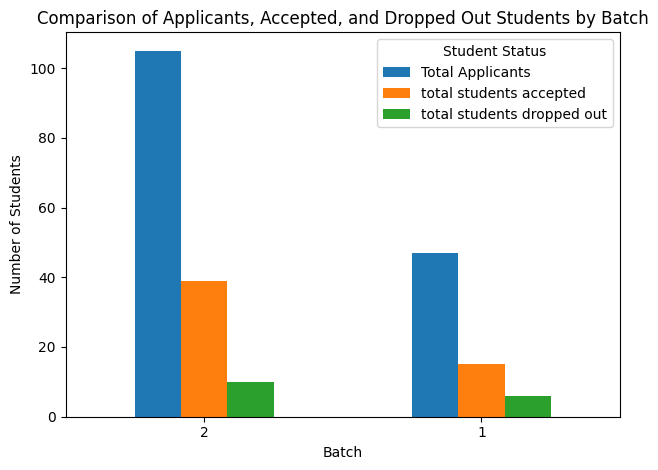

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size
plt.figure(figsize=(10, 6))

# Plotting side-by-side bars
summary_data.plot(x='Batch',
                 y=['Total Applicants', 'total students accepted', 'total students dropped out'],
                 kind='bar')

# Adding titles and labels
plt.title('Comparison of Applicants, Accepted, and Dropped Out Students by Batch')
plt.xlabel('Batch')
plt.xticks(rotation=0)
plt.ylabel('Number of Students')

# Display the legend and show the plot
plt.legend(title='Student Status')
plt.tight_layout()
plt.show()

Total Number of students who got accepted to the program:54
Number of students who dropped : 16 students.
Percentage of dropouts: 29.63%


<>:5: SyntaxWarning: invalid escape sequence '\('
<>:5: SyntaxWarning: invalid escape sequence '\('
C:\Users\User\AppData\Local\Temp\ipykernel_18084\4019700766.py:5: SyntaxWarning: invalid escape sequence '\('
  combined_df['Location'] = combined_df['Location'].replace({'Thailand \(.*?\)': 'Thailand'}, regex=True)


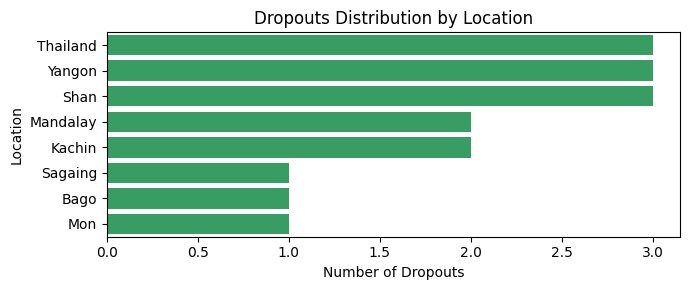

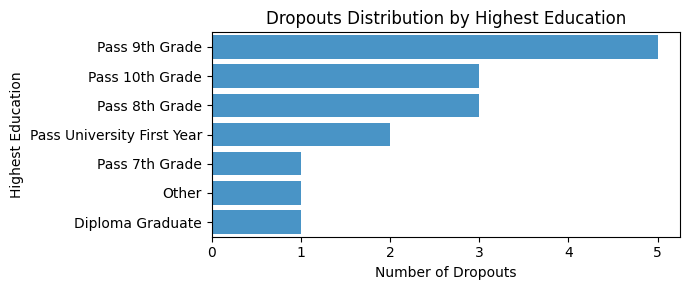

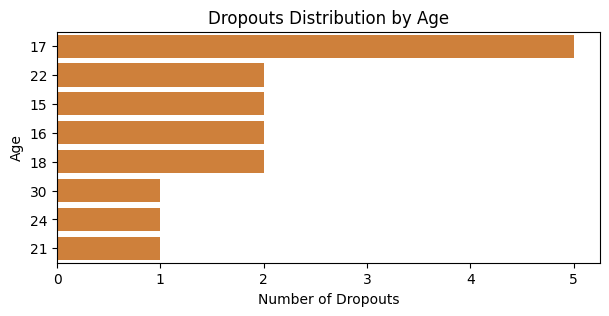

In [23]:
# Apply 10-point scale normalization based on batch
# combined_df['Pre_Eng'] = np.where(combined_df['Batch'] == 2, (combined_df['Pre_Eng'] / 100) * 10, (combined_df['Pre_Eng'] / 50) * 10)
# combined_df['Pre_Math'] = np.where(combined_df['Batch'] == 2, (combined_df['Pre_Math'] / 100) * 10, (combined_df['Pre_Math'] / 50) * 10)
# combined_df['Final Score'] = round((combined_df['Pre_Eng']+combined_df['Pre_Math'])/2,2)
combined_df['Location'] = combined_df['Location'].replace({'Thailand \(.*?\)': 'Thailand'}, regex=True)
#Filter students pass and fail
dropout = combined_df[(combined_df['Remark'] == 'Drop Out')]   #& (b2_ent_merge['Final Score'] > 60)]

# Count and calculate percentage
num_dropout = dropout.shape[0]
#total_students = combined_df[combined_df['Final Score'] > 60].shape[0]
total_students = combined_df.shape[0]
percentage_dropout = (num_dropout / total_students) * 100

print(f"Total Number of students who got accepted to the program:{total_students}")
print(f"Number of students who dropped : {num_dropout} students.")
print(f"Percentage of dropouts: {percentage_dropout:.2f}%")

# # Check distribution by Location
# location_distribution = dropout_above_60['Location'].value_counts()
# print("Dropouts with Final Score > 60 by Location:\n", location_distribution)

# # Check distribution by Age
# age_distribution = dropout['Age'].value_counts()
# print("\nDropouts with Final Score > 60 by Age:\n", age_distribution)


# Visualization 1: Dropouts with Final Score > 60 by Location
plt.figure(figsize=(7, 3))
# Get counts of each category in descending order
location_counts = dropout['Location'].value_counts().index
sns.countplot(y='Location', data=dropout, color='#27ae60',order=location_counts)
plt.title('Dropouts Distribution by Location')
#plt.ylabel('Location')
plt.xlabel('Number of Dropouts')
#plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 3))
high_edu_counts = dropout['Highest Education'].value_counts().index
sns.countplot(y='Highest Education', data=dropout , color='#3498db',order=high_edu_counts)
plt.title('Dropouts Distribution by Highest Education')
#plt.ylabel('Highest Education')
plt.xlabel('Number of Dropouts')
#plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

# Visualization 2: Dropouts with Final Score > 60 by Age
plt.figure(figsize=(7, 3))
age_counts = dropout['Age'].value_counts().index
sns.countplot(y='Age', data=dropout , color='#e67e22',order=age_counts)
plt.title('Dropouts Distribution by Age')
plt.ylabel('Age')
plt.xlabel('Number of Dropouts')
plt.show()


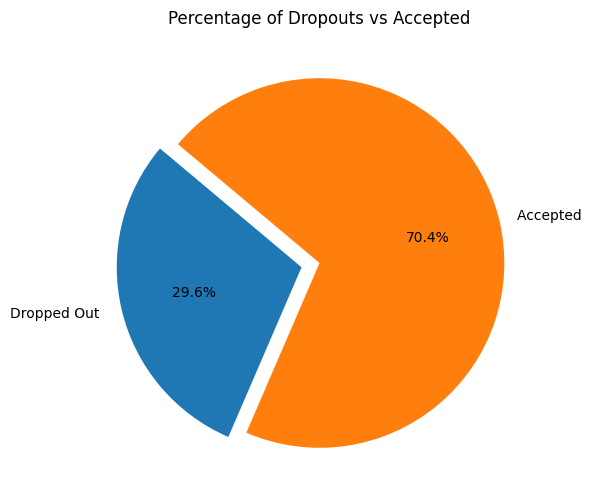

In [24]:
# Data for pie chart
sizes = [num_dropout, total_students - num_dropout]
#colors = ['#ff9999','#66b3ff']
explode = (0.1, 0)  # explode 1st slice to highlight dropouts
labels = ['Dropped Out ', 'Accepted ']

# Plot
plt.figure(figsize=(8, 6))
#explode is an optional parameter that is used to "pull out" or "highlight" specific slices of the pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, explode=explode)
plt.title("Percentage of Dropouts vs Accepted")
plt.show()

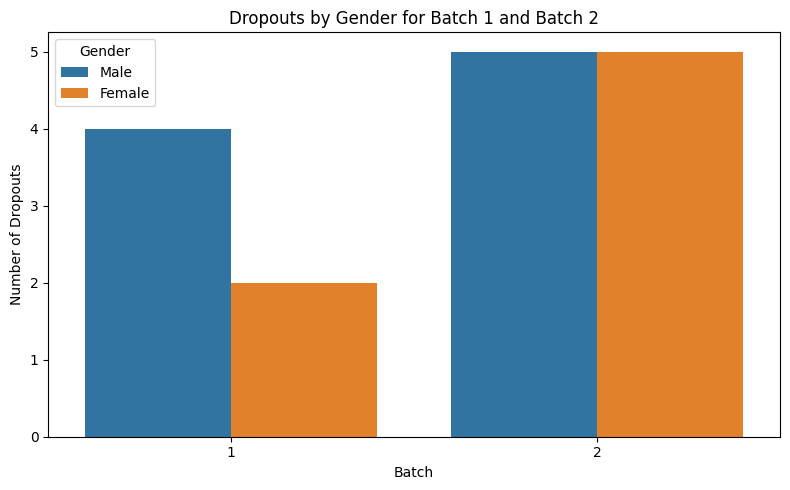

In [25]:
url='https://docs.google.com/spreadsheets/d/13CvxCHxLn6CPsDCXa6_FZgMsFm9tnKzkvyzJadc0eHM/gviz/tq?tqx=out:csv'
dropout_gender = convert_to_df(file_info_paths=[(url,'utf-8','dropout_gender')])
dropout_gender = dropout_gender['dropout_gender']
dropout_gender.head()

#Filter students pass and fail
dropout = dropout_gender[(dropout_gender['Remarks'] == 'Drop Out')]   #& (b2_ent_merge['Final Score'] > 60)]
# Plot using seaborn's countplot
plt.figure(figsize=(8, 5))
sns.countplot(data=dropout, x='Batch', hue='Gender')
plt.title('Dropouts by Gender for Batch 1 and Batch 2')
plt.xlabel('Batch')
plt.ylabel('Number of Dropouts')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()

# **Interview Score Analysis**

Interview column is only existed in Batch 2.
So, check interview score performance and its weight to understand the importance of the feature.
By checking this interview proportion, we can conclude that it is contributed around **52%** to pass the entrance.
So we might need to notify students interview is important to get accepted so that they will prepare the interview session more seriously insted of just trying the luck

Given that the average interview proportion is 33%, you can conclude that interview performance is
important for acceptance. If the analyses above show that high interview proportions correlate with 
high final scores or that accepted students tend to have higher interview proportions,
it reinforces the importance of performing well in the interview.

In [26]:
# Now calculate the interview_proportion for Batch 2
b2_ent_score_df.loc[:, 'interview_proportion'] =  round(b2_ent_score_df['Interview'] / ( b2_ent_score_df['English']+ b2_ent_score_df['Math']+ b2_ent_score_df['Interview']),2)
#print(b2_ent_score_df[['Final Score']])
# Calculate the average interview proportion for Batch 2
avg_interview_proportion =  round(b2_ent_score_df['interview_proportion'].mean(),2)

# Print the result
print(f"Average interview contribution to pass the entrance is :{avg_interview_proportion}")
print(f"Correlation between interview score and fincal score is:{round(b2_ent_score_df['Interview'].corr(b2_ent_score_df['Final Score']),2)}")
#b2_ent_score_df[b2_ent_score_df['Pass/Fail'] == 'Pass']

Average interview contribution to pass the entrance is :0.33
Correlation between interview score and fincal score is:0.94


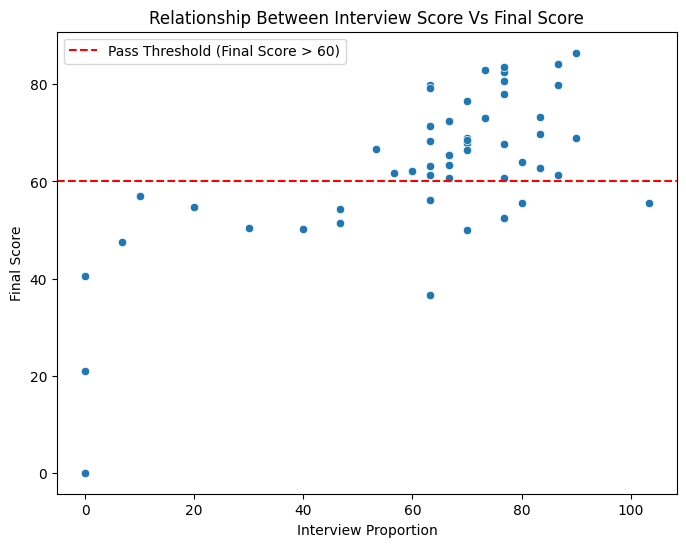

In [27]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=b2_ent_score_df, x='Interview', y='Final Score')
plt.axhline(60, color='red', linestyle='--', label="Pass Threshold (Final Score > 60)")
plt.title('Relationship Between Interview Score Vs Final Score')
plt.xlabel("Interview Proportion")
plt.ylabel("Final Score")
plt.legend()
plt.show()

# Entrance Score EDA

In [28]:
cols_to_keep=['Student ID','Num_subjects_taken','Remark','Pre_Eng','Pre_Math','Age','Location','Highest Education','Batch','Final Score']
selected_pre_df = combined_df[cols_to_keep]

# Combine the Thailand columns with regex
#this regex pattern matches any string that starts with "Thailand" and has anything (or nothing) in parentheses following it
selected_pre_df['Location'] = selected_pre_df['Location'].replace({'Thailand \(.*?\)': 'Thailand'}, regex=True)
selected_pre_df.head()
#print(type(selected_pre_df))

# do 10-point scale normalization for pre entrance score as well to do fair comparison with post scores
max_score = 100 if selected_pre_df['Batch'].iloc[0] == 2 else 50
# Apply 10-point scale normalization based on batch
selected_pre_df['Pre_Eng'] = np.where(selected_pre_df['Batch'] == 2, (selected_pre_df['Pre_Eng'] / 100) * 10, (selected_pre_df['Pre_Eng'] / 50) * 10)
selected_pre_df['Pre_Math'] = np.where(selected_pre_df['Batch'] == 2, (selected_pre_df['Pre_Math'] / 100) * 10, (selected_pre_df['Pre_Math'] / 50) * 10)
selected_pre_df['Final Score'] = round((selected_pre_df['Pre_Eng']+selected_pre_df['Pre_Math'])/2,2)

print(selected_pre_df.tail())


     Student ID    Num_subjects_taken    Remark    Pre_Eng  Pre_Math  Age Location Highest Education  Batch  Final Score
50  GED202402_100           4                 NaN    8.0       8.5    16   Yangon     Pass 8th Grade    2       8.25    
51  GED202402_101           4                 NaN    5.8       8.0    19    Kayin    Pass 10th Grade    2       6.90    
52  GED202402_102           4                 NaN    8.4       9.0    18   Yangon     Pass 9th Grade    2       8.70    
53  GED202402_104           4                 NaN    6.4       9.0    17   Yangon     Pass 9th Grade    2       7.70    
54  GED202402_105           4          Substitute    3.2       3.2    16      Mon     Pass 9th Grade    2       3.20    


<>:6: SyntaxWarning: invalid escape sequence '\('
<>:6: SyntaxWarning: invalid escape sequence '\('
C:\Users\User\AppData\Local\Temp\ipykernel_18084\728224633.py:6: SyntaxWarning: invalid escape sequence '\('
  selected_pre_df['Location'] = selected_pre_df['Location'].replace({'Thailand \(.*?\)': 'Thailand'}, regex=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18084\728224633.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_pre_df['Location'] = selected_pre_df['Location'].replace({'Thailand \(.*?\)': 'Thailand'}, regex=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18084\728224633.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [29]:
selected_pre_df.groupby('Batch')['Final Score'].agg(['max','min','mean'])

,max,min,mean
Batch,,,
1,8.0,4.5,6.615333
2,8.7,3.2,6.914103


In [30]:
selected_pre_df[['Pre_Eng','Pre_Math','Final Score']].describe()

,Pre_Eng,Pre_Math,Final Score
count,54.000000,54.000000,54.000000
mean,6.396296,7.265815,6.831111
std,1.378263,1.487892,1.154198
min,3.200000,3.200000,3.200000
25%,5.400000,6.400000,6.225000
50%,6.400000,7.200000,6.750000
75%,7.700000,8.000000,7.675000
max,8.800000,10.000000,8.700000


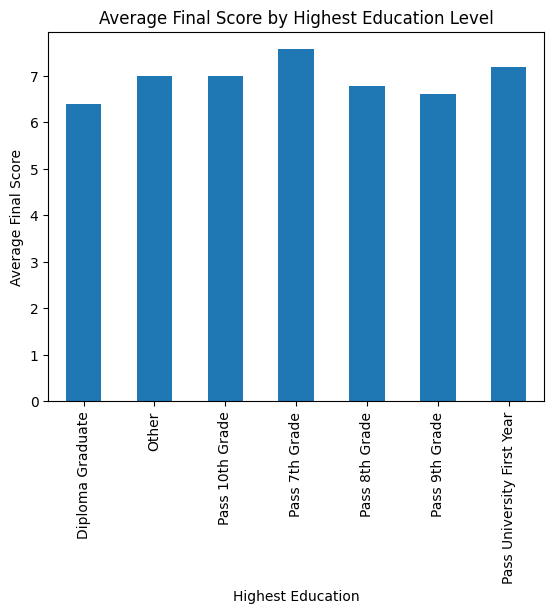

In [31]:
# Impact of highest education
education_performance = selected_pre_df.groupby('Highest Education')['Final Score'].mean()  #.reset_index()
#education_performance.sort_values(by='n_Final_Score', ascending=False)
education_performance.plot(kind='bar')
plt.title('Average Final Score by Highest Education Level')
plt.ylabel('Average Final Score')
plt.show()

     Location   Final Score
3       Magway   8.466667  
8   Taninthary   7.950000  
0         Bago   7.400000  
6      Sagaing   7.212500  
2        Kayin   7.200000  
10      Yangon   6.986364  
1       Kachin   6.950000  
4     Mandalay   6.742857  
7         Shan   5.916667  
5          Mon   5.766000  
9     Thailand   5.700000  


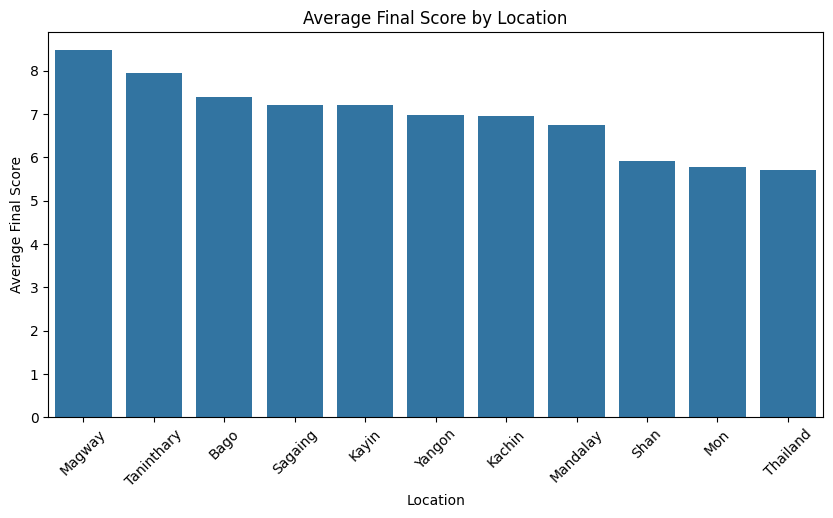

In [32]:
location_performance = selected_pre_df.groupby('Location')['Final Score'].mean().reset_index()
location_performance = location_performance.sort_values(by='Final Score', ascending=False)
# Display the result
print(location_performance)

# Plot the average Final Score by Location
plt.figure(figsize=(10, 5))
sns.barplot(x='Location', y='Final Score', data=location_performance)
plt.title('Average Final Score by Location')
plt.xlabel('Location')
plt.ylabel('Average Final Score')
plt.xticks(rotation=45)
plt.show()

# it is really surprising and amazing to see which locations scores the higheset mean.

# We are now Done with Entrance Analysis.
To make furthur pre Vs post analysis, we need to combined the entrance data, exam scores data after joining program and surverys from students and teachers.

Lets recall our multiple data sets we have loaded into our dataframes.

**Exam scores by batch 2**:
sci_scores,
math_scores,
ss_scores,
rla_scores

**Exam scores by batch 2(due to some system error, only able to retrieve 3 students data only)**:
b1_sci_scores, 
b1_rla_scores, 
b1_math_scores,
b1_ss_score,

**Student participation survery from teachers**:
student_ptc_info_df

**student feedback from students**:
pj2_survey_df

**attendance data for both batch**:
att_df

**Accepted student data**:
selected_pre_df

Please note that we only have pre scores for only math and english

# Pre and Post scores Analysis

In [33]:
#filter only the actual participants in the program, remove Drop Out 
selected_pre_df = selected_pre_df[selected_pre_df['Remark'] != 'Drop Out']
selected_pre_df.head()

,Student ID,Num_subjects_taken,Remark,Pre_Eng,Pre_Math,Age,Location,Highest Education,Batch,Final Score
1,GED2024002,3,"Math , Science, Rla",7.8,7.6,16,Mandalay,Pass 7th Grade,1,7.7
2,GED2024003,4,NaN,7.4,7.2,19,Sagaing,Pass 10th Grade,1,7.3
4,GED2024006,4,NaN,6.6,5.6,16,Yangon,Pass 8th Grade,1,6.1
5,GED2024007,4,NaN,8.4,7.2,18,Yangon,Pass 10th Grade,1,7.8
6,GED2024008,4,NaN,5.4,6.0,17,Yangon,Pass 9th Grade,1,5.7


In [34]:
math_scores.columns

Index(['Email address', 'Grade/10.00_math_test2', 'Grade/10.00_math_test3',
       'Grade/10.00_math_test6', 'Student ID', 'Batch', 'n_math_test1',
       'avg_math'],
      dtype='object')

In [35]:
scores_df = math_scores.merge(rla_scores, on='Email address',how='outer',suffixes=('','_post'))\
        .merge(sci_scores, on='Email address',how='outer', suffixes=('','_post'))\
        .merge(ss_scores, on='Email address',how='outer',suffixes=('','_post'))
        #.merge(selected_pre_df,on='Student ID',how='left',suffixes=('','_pre'))
print(scores_df.shape)

col_to_drop = ['Student ID_post','Batch_post'] # remove duplicated columns
scores_df.drop(columns=col_to_drop,inplace=True)


print(scores_df.isna().sum())
scores_df = scores_df.drop(columns='Grade/10.00_rla_test3') # remove since all are Nan vlaues, Not yet graded
#print(scores_df.columns)

(29, 27)
Email address              0
Grade/10.00_math_test2     4
Grade/10.00_math_test3     6
Grade/10.00_math_test6     4
Student ID                 3
Batch                      1
n_math_test1               4
avg_math                   1
Grade/10.00_rla_test1      8
Grade/10.00_rla_test2      8
Grade/10.00_rla_test3     15
avg_rla                    5
Grade/10.00_sci_test1      3
Grade/10.00_sci_test2      4
Grade/10.00_sci_test3      5
Grade/10.00_sci_test4      5
avg_sci                    1
n_ss_test1                 2
n_ss_test2                16
n_ss_test3                 2
avg_ss                     0
dtype: int64


In [36]:
# # Identify email addresses in rla_scores that are not in math_scores
# # sanity check only, to remove later
# missing_emails = sci_scores[~sci_scores['Email address'].isin(rla_scores['Email address'])]

# # Print the missing email addresses
# if not missing_emails.empty:
#     print("Email addresses not included in math_scores:")
#     print(missing_emails['Email address'])
# else:
#     print("All email addresses are included in math_scores.")

# just for validation purposes, not included in analysis
missing_id = scores_df[~scores_df['Student ID'].isin(selected_pre_df['Student ID'])]

# Print the missing email addresses
if not missing_id.empty:
    print("ID not included in math_scores:")
    print(missing_id['Student ID'])
else:
    print("All ID are included in math_scores.")

ID not included in math_scores:
17    NaN
24    NaN
27    NaN
Name: Student ID, dtype: object


In [37]:
# fill na values based on the class avg, since some students don't have record at all.
score_col = [
    'Grade/10.00_math_test2','Grade/10.00_math_test3','Grade/10.00_math_test6','n_math_test1','avg_math',
    'Grade/10.00_rla_test1','Grade/10.00_rla_test2','avg_rla',
    'Grade/10.00_sci_test1','Grade/10.00_sci_test2','Grade/10.00_sci_test3','Grade/10.00_sci_test4','avg_sci',
    'n_ss_test1','n_ss_test2','n_ss_test3','avg_ss'
]
scores_df[score_col]= round(scores_df[score_col].fillna(scores_df[score_col].mean()),2)
scores_df.isna().sum()

Email address             0
Grade/10.00_math_test2    0
Grade/10.00_math_test3    0
Grade/10.00_math_test6    0
Student ID                3
Batch                     1
n_math_test1              0
avg_math                  0
Grade/10.00_rla_test1     0
Grade/10.00_rla_test2     0
avg_rla                   0
Grade/10.00_sci_test1     0
Grade/10.00_sci_test2     0
Grade/10.00_sci_test3     0
Grade/10.00_sci_test4     0
avg_sci                   0
n_ss_test1                0
n_ss_test2                0
n_ss_test3                0
avg_ss                    0
dtype: int64

In [38]:
scores_df[scores_df['Student ID'].isna()]

,Email address,Grade/10.00_math_test2,Grade/10.00_math_test3,Grade/10.00_math_test6,Student ID,Batch,n_math_test1,avg_math,Grade/10.00_rla_test1,Grade/10.00_rla_test2,avg_rla,Grade/10.00_sci_test1,Grade/10.00_sci_test2,Grade/10.00_sci_test3,Grade/10.00_sci_test4,avg_sci,n_ss_test1,n_ss_test2,n_ss_test3,avg_ss
17,myatkokokhant@gmail.com,8.44,8.46,7.69,NaN,NaN,8.9,8.35,7.22,7.56,7.29,7.65,7.67,7.63,7.84,7.61,7.15,7.23,6.14,6.14
24,valnxiris@gmail.com,8.44,9.23,7.06,NaN,2.0,9.2,8.48,10.00,8.97,9.48,7.00,8.82,9.80,9.82,8.86,9.00,8.09,8.18,8.43
27,yuuyii483@gmail.com,10.00,10.00,7.65,NaN,2.0,9.0,9.16,8.33,8.97,8.65,8.00,7.65,7.12,8.25,7.76,7.00,7.62,8.77,7.80


In [39]:
#fill student ID
id_map = {
    'valnxiris@gmail.com': 'GED202402_73',
    'yuuyii483@gmail.com': 'GED202402_102',
    'myatkokokhant@gmail.com': 'GED202402_105'
}
# Use map to fill in the 'Student ID' based on 'Email address'
scores_df['Student ID'] = scores_df['Email address'].map(id_map).fillna(scores_df['Student ID'])

scores_df.isna().sum()

Email address             0
Grade/10.00_math_test2    0
Grade/10.00_math_test3    0
Grade/10.00_math_test6    0
Student ID                0
Batch                     1
n_math_test1              0
avg_math                  0
Grade/10.00_rla_test1     0
Grade/10.00_rla_test2     0
avg_rla                   0
Grade/10.00_sci_test1     0
Grade/10.00_sci_test2     0
Grade/10.00_sci_test3     0
Grade/10.00_sci_test4     0
avg_sci                   0
n_ss_test1                0
n_ss_test2                0
n_ss_test3                0
avg_ss                    0
dtype: int64

In [40]:
scores_df.shape

(29, 20)

In [41]:
selected_pre_df.shape 

(38, 10)

In [42]:
pre_post_df=scores_df.merge(selected_pre_df,on='Student ID',how='left',suffixes=('','_pre')).merge(att_df,on='Student ID',how='left',suffixes=('','_att')).merge(pj2_survey_df,on='Student ID',how='left',suffixes=('','_sv')).merge(student_ptc_info_df,on='Student ID',how='left',suffixes=('','_ptc'))
#make sure no rows are dropped after merge
pre_post_df.shape

(29, 69)

In [43]:
#rename confusing column name
pre_post_df.rename({'Final Score':'Pre_avg_score'},inplace=True,axis=1)

In [44]:
pre_post_df.columns

Index(['Email address', 'Grade/10.00_math_test2', 'Grade/10.00_math_test3',
       'Grade/10.00_math_test6', 'Student ID', 'Batch', 'n_math_test1',
       'avg_math', 'Grade/10.00_rla_test1', 'Grade/10.00_rla_test2', 'avg_rla',
       'Grade/10.00_sci_test1', 'Grade/10.00_sci_test2',
       'Grade/10.00_sci_test3', 'Grade/10.00_sci_test4', 'avg_sci',
       'n_ss_test1', 'n_ss_test2', 'n_ss_test3', 'avg_ss',
       'Num_subjects_taken', 'Remark', 'Pre_Eng', 'Pre_Math', 'Age',
       'Location', 'Highest Education', 'Batch_pre', 'Pre_avg_score',
       'att_rla', 'att_sci', 'att_math', 'att_ss', 'Batch_att',
       'confidence_bef_math', 'confidence_bef_rla', 'confidence_bef_sci',
       'confidence_bef_ss', 'confidence_aft_math', 'confidence_aft_rla',
       'confidence_aft_sci', 'confidence_aft_ss', 'Expectations_Met',
       'math_improvement', 'sci_improvement', 'ss_improvement',
       'rla_improvement', 'most_improved_sub', 'overall_improvement_bef',
       'overall_improvement_af

In [45]:
pre_post_df['avg_att'] = pre_post_df[['att_rla','att_sci','att_math','att_ss']].mean(axis=1)
pre_post_df['avg_att'].fillna(pre_post_df['avg_att'].mean(), inplace=True)
pre_post_df['avg_att'] = round(pre_post_df['avg_att'],2)
pre_post_df[['avg_att']].head()

C:\Users\User\AppData\Local\Temp\ipykernel_18084\3347700361.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  pre_post_df['avg_att'].fillna(pre_post_df['avg_att'].mean(), inplace=True)


,avg_att
0,90.58
1,91.45
2,94.55
3,99.68
4,93.98


In [46]:
pre_post_df['avg_post_all_sub'] = round(pre_post_df[['avg_rla','avg_math','avg_ss','avg_sci']].mean(axis=1),2)
pre_post_df[['avg_post_all_sub']].head()

,avg_post_all_sub
0,6.85
1,7.11
2,7.85
3,8.65
4,7.97


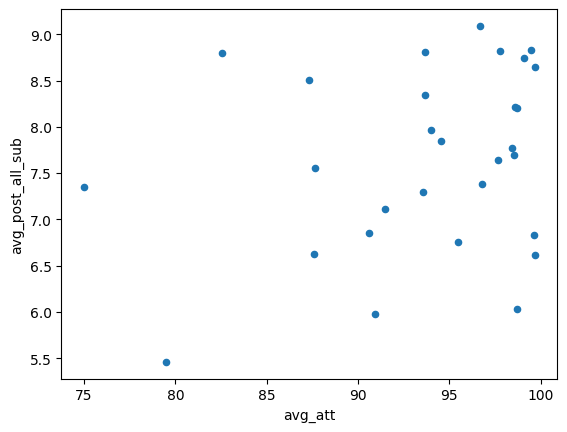

0.2634418859845091


In [47]:
pre_post_df.plot(kind='scatter',x='avg_att',y='avg_post_all_sub')
plt.show()
att_corr = pre_post_df['avg_post_all_sub'].corr(pre_post_df['avg_att'])
print(att_corr)

In [48]:
pre_post_df['math_imp_%'] = ((pre_post_df['avg_math'] -pre_post_df['Pre_Math'])/pre_post_df['Pre_Math'])*100
pre_post_df[['Student ID','avg_math','Pre_Math','math_imp_%']]

,Student ID,avg_math,Pre_Math,math_imp_%
0,GED202402_104,6.86,9.0,-23.777778
1,GED202402_94,8.36,8.0,4.500000
2,GED202402_67,8.48,9.0,-5.777778
3,GED202402_09,8.71,5.0,74.200000
4,GED202402_92,8.77,6.0,46.166667
5,GED202402_25,9.80,9.0,8.888889
6,GED202402_58,6.18,6.5,-4.923077
7,GED202402_19,6.62,8.0,-17.250000
8,GED202402_07,8.59,6.0,43.166667
9,GED202402_85,9.31,9.5,-2.000000


In [49]:
pre_post_df['rla_imp_%'] = ((pre_post_df['avg_rla'] -pre_post_df['Pre_Eng'])/pre_post_df['Pre_Eng'])*100
pre_post_df[['Student ID','avg_rla','Pre_Eng','rla_imp_%']]

,Student ID,avg_rla,Pre_Eng,rla_imp_%
0,GED202402_104,6.11,6.4,-4.531250
1,GED202402_94,4.44,8.6,-48.372093
2,GED202402_67,7.27,4.6,58.043478
3,GED202402_09,8.82,5.8,52.068966
4,GED202402_92,7.59,4.8,58.125000
5,GED202402_25,9.38,8.0,17.250000
6,GED202402_58,7.29,8.0,-8.875000
7,GED202402_19,7.29,4.8,51.875000
8,GED202402_07,7.59,7.0,8.428571
9,GED202402_85,7.16,6.4,11.875000


In [50]:
pre_post_df['sci_imp_%'] = ((pre_post_df['avg_sci'] -pre_post_df['Pre_avg_score'])/pre_post_df['Pre_avg_score'])*100
pre_post_df[['Student ID','Pre_avg_score','avg_sci','sci_imp_%']]

,Student ID,Pre_avg_score,avg_sci,sci_imp_%
0,GED202402_104,7.70,7.67,-0.389610
1,GED202402_94,8.30,7.66,-7.710843
2,GED202402_67,6.80,8.21,20.735294
3,GED202402_09,5.40,8.51,57.592593
4,GED202402_92,5.40,8.36,54.814815
5,GED202402_25,8.50,8.06,-5.176471
6,GED202402_58,7.25,8.57,18.206897
7,GED202402_19,6.40,3.00,-53.125000
8,GED202402_07,6.50,6.52,0.307692
9,GED202402_85,7.95,10.00,25.786164


In [51]:
pre_post_df['ss_imp_%'] = ((pre_post_df['avg_ss'] -pre_post_df['Pre_avg_score'])/pre_post_df['Pre_avg_score'])*100
pre_post_df[['Student ID','Pre_avg_score','ss_imp_%']]

,Student ID,Pre_avg_score,ss_imp_%
0,GED202402_104,7.70,-12.337662
1,GED202402_94,8.30,-3.855422
2,GED202402_67,6.80,9.117647
3,GED202402_09,5.40,58.703704
4,GED202402_92,5.40,32.592593
5,GED202402_25,8.50,7.058824
6,GED202402_58,7.25,-1.517241
7,GED202402_19,6.40,-23.125000
8,GED202402_07,6.50,24.461538
9,GED202402_85,7.95,-4.654088


In [52]:
# Function to categorize scores for each subject
def categorize_score(score, subject):
    if score < 7:
        return "Needs Preparation"
    elif score >= 8.7:
        return "Credit"
    else:
        return "Pass"    #score greater than 7 and score less than 8.7

# Categorize each subject
for subject in ['avg_math', 'avg_rla', 'avg_sci', 'avg_ss']:
    pre_post_df[f'{subject}_category'] = pre_post_df[subject].apply(lambda x: categorize_score(x, subject))

# Count students in each category for each subject
category_counts = (
    pre_post_df.melt(id_vars='Student ID', 
                     value_vars=['avg_math_category', 'avg_rla_category', 'avg_sci_category', 'avg_ss_category'], 
                     var_name='Subject', 
                     value_name='Category')
    .groupby(['Subject', 'Category'])
    .size()
    .reset_index(name='Number of Students')
)

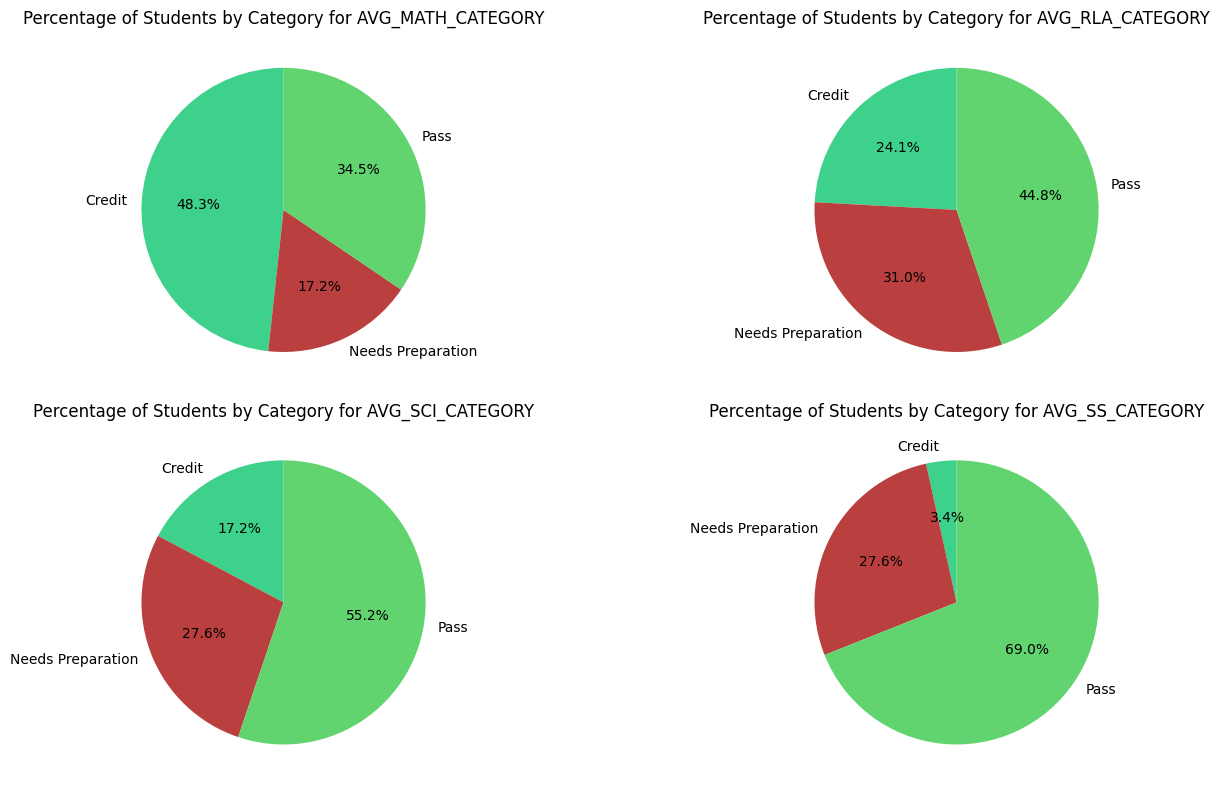

In [53]:
# Calculate the percentage for each category per subject
category_counts['Percentage'] = category_counts.groupby('Subject')['Number of Students'].transform(lambda x: x / x.sum() * 100)

# Plotting Pie Charts
subjects = category_counts['Subject'].unique()

# Create a pie chart for each subject
plt.figure(figsize=(15, 8))
for i, subject in enumerate(subjects, start=1):
    plt.subplot(2, 2, i)
    subject_data = category_counts[category_counts['Subject'] == subject]
    plt.pie(subject_data['Percentage'], labels=subject_data['Category'], autopct='%1.1f%%', startangle=90, colors=['#3dd18c','#ba3f3f','#61d46f' ])
    # plt.pie(subject_data['Percentage'], labels=subject_data['Category'], autopct='%1.1f%%', startangle=90)
    plt.title(f'Percentage of Students by Category for {subject.upper()}')

plt.tight_layout()
plt.show()

#custom_colors = ['#27ae60',#34495e,'#3498db','#2ecc71','#ecf0f1']

In [54]:
# pre_post_df['Pre_Score_Band'] = pd.cut(pre_post_df['Pre_Eng'], bins=[0, 4, 6, 8, 10], labels=['0-4', '4-6', '6-8', '8-10'])
# pre_post_df[['Pre_Eng','Pre_Score_Band','rla_imp_%']]
# # score_band_means = pre_post_df.groupby('Pre_Score_Band')['rla_imp_%'].mean().reset_index()
# sns.barplot(x='Pre_Score_Band', y='rla_imp_%', data=score_band_means)
# plt.xlabel("Pre-Test Score Band")
# plt.ylabel("Average Improvement (%)")
# plt.title("Average Improvement Percentage by Pre-Test Score Band")
# plt.show()

In [55]:
# sns.lmplot(x='Pre_Eng', y='avg_rla', data=pre_post_df, aspect=1.5, scatter_kws={"s": 50, "alpha": 0.5})
# plt.title("Correlation Between Pre-Test and Post-Test RLA Scores")
# plt.xlabel("Pre-Test Score")
# plt.ylabel("Post-Test Score")
# plt.show()
# Compare average improvement percentages across subjects to see where students have progressed the most.
# This gives a quick view of which subjects have the highest average improvement, indicating which subjects students improved in most significantly.

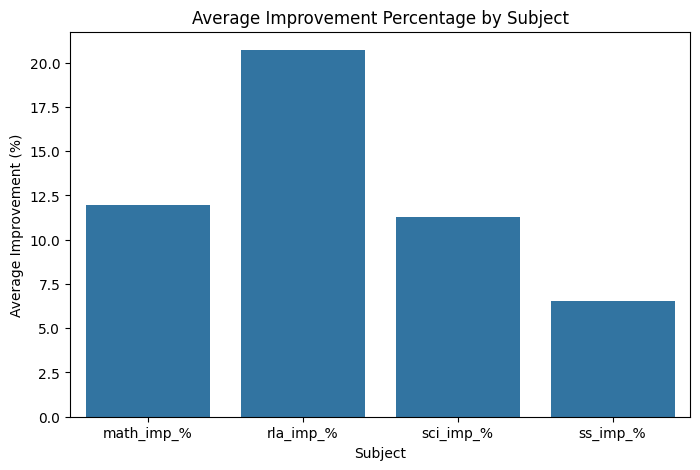

In [56]:
subs_imp = ['math_imp_%', 'rla_imp_%', 'sci_imp_%', 'ss_imp_%']
avg_improvements = pre_post_df[subs_imp].mean()
plt.figure(figsize=(8, 5))
sns.barplot(x=avg_improvements.index, y=avg_improvements.values)
plt.title("Average Improvement Percentage by Subject")
plt.xlabel("Subject")
plt.ylabel("Average Improvement (%)")
plt.show()

In [57]:
# top_students = pre_post_df.nlargest(5, 'math_imp_%')[['Student ID', 'math_imp_%']]
# bottom_students = pre_post_df.nsmallest(5, 'math_imp_%')[['Student ID', 'math_imp_%']]

# plt.figure(figsize=(8, 5))
# sns.barplot(data=top_students, x='math_imp_%', y='Student ID', color='green', label='Top 5')
# sns.barplot(data=bottom_students, x='math_imp_%', y='Student ID', color='red', label='Bottom 5')
# plt.title("Top and Bottom Performers in Math Improvement")
# plt.xlabel("Improvement Percentage")
# plt.ylabel("Student ID")
# plt.legend()
# plt.show()

In [58]:
# plt.figure(figsize=(12, 6))
# sns.lineplot(data=pre_post_df[['Student ID', 'math_imp_%', 'rla_imp_%', 'sci_imp_%', 'ss_imp_%']].melt(id_vars='Student ID'), x='Student ID', y='value', hue='variable')
# plt.xticks(rotation=90)
# plt.title("Student-wise Improvement Percentage by Subject")
# plt.xlabel("Student ID")
# plt.ylabel("Improvement (%)")
# plt.legend(title="Subject")
# plt.show()

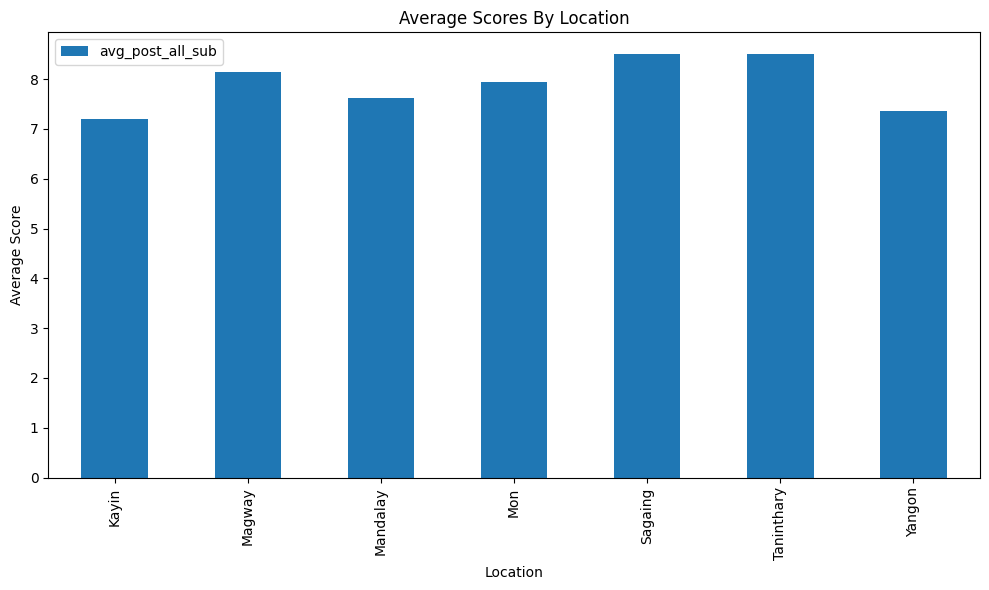

In [59]:
# pre_post_df[['avg_math', 'avg_sci', 'avg_ss', 'avg_rla']].plot(kind='bar')
# plt.show()
#location_avg_scores = pre_post_df.groupby('Highest Education')[['avg_math', 'avg_sci', 'avg_ss', 'avg_rla']].mean()
#location_avg_scores = pre_post_df.groupby('Age')[['avg_math', 'avg_sci', 'avg_ss', 'avg_rla']].mean()
#location_avg_scores = pre_post_df.groupby('Location')[['avg_math', 'avg_sci', 'avg_ss', 'avg_rla']].mean()
location_avg_scores = pre_post_df.groupby('Location')[['avg_post_all_sub']].mean()
# Plot the average scores by Location
location_avg_scores.plot(kind='bar', figsize=(10, 6))
plt.title('Average Scores By Location')
plt.ylabel('Average Score')
#plt.legend(title='Avg Subjects')
plt.tight_layout()  # Adjust layout to make room for labels
plt.show()

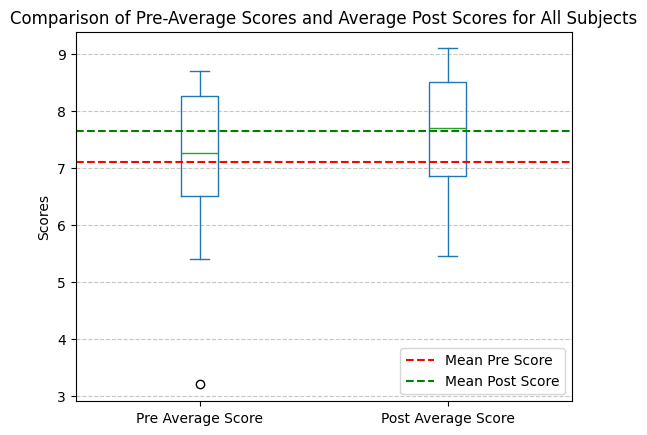

In [60]:
pre_post_df[['Pre_avg_score', 'avg_post_all_sub']].plot(kind='box')
# Add labels and title
plt.title('Comparison of Pre-Average Scores and Average Post Scores for All Subjects')
plt.ylabel('Scores')
plt.xticks([1, 2], ['Pre Average Score', 'Post Average Score'])

# Optionally add gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Optionally show mean
plt.axhline(y=pre_post_df['Pre_avg_score'].mean(), color='r', linestyle='--', label='Mean Pre Score')
plt.axhline(y=pre_post_df['avg_post_all_sub'].mean(), color='g', linestyle='--', label='Mean Post Score')
plt.legend()
plt.show()

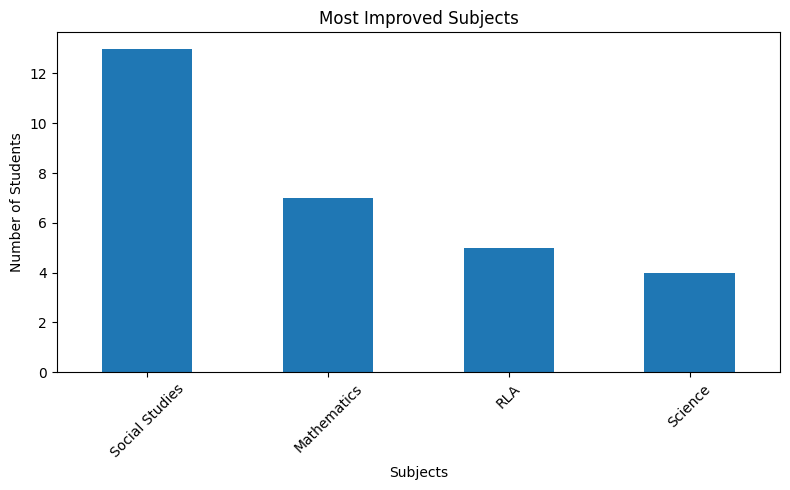

In [61]:
# Count occurrences of each subject
most_improved_counts = pj2_survey_df['most_improved_sub'].value_counts()
most_improved_counts.plot(kind='bar', figsize=(8, 5))
plt.title('Most Improved Subjects')
plt.xlabel('Subjects')
plt.ylabel('Number of Students')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to make room for labels
plt.show()

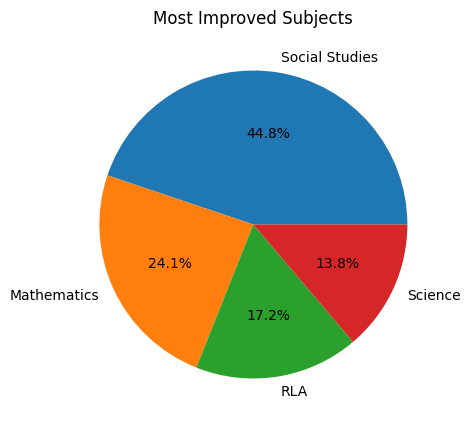

In [62]:
most_improved_counts.plot(kind='pie', autopct='%1.1f%%', figsize=(8, 5))
plt.title('Most Improved Subjects')
plt.ylabel('')  # Hide the y-label
plt.show()

In [63]:
student_ptc_info_df.columns

Index(['Student ID', 'Attention_In_Class_math', 'Active_Engagement_math',
       'Group_Participation_math', 'Clear_Answers_math',
       'Attention_In_Class_sci', 'Active_Engagement_sci',
       'Group_Participation_sci', 'Clear_Answers_sci', 'Attention_In_Class_ss',
       'Active_Engagement_ss', 'Group_Participation_ss', 'Clear_Answers_ss',
       'Attention_In_Class_rla', 'Active_Engagement_rla',
       'Group_Participation_rla', 'Clear_Answers_rla'],
      dtype='object')

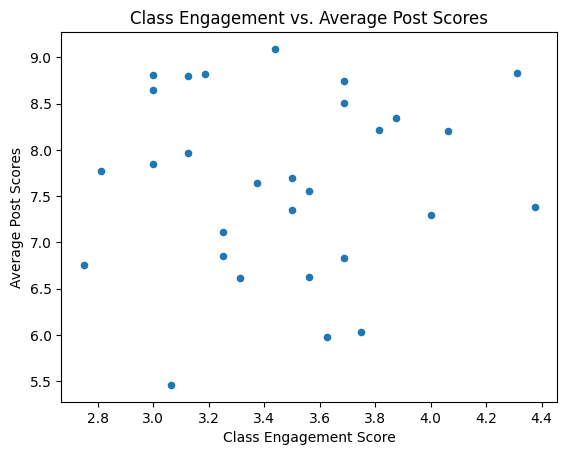

0.061295406899090875


In [64]:
pre_post_df['class_engage'] =pre_post_df[['Attention_In_Class_rla','Active_Engagement_rla','Group_Participation_rla','Clear_Answers_rla',
                                         'Attention_In_Class_math','Active_Engagement_math','Group_Participation_math','Clear_Answers_math',
                                         'Attention_In_Class_sci','Active_Engagement_sci','Group_Participation_sci','Clear_Answers_sci',
                                         'Attention_In_Class_ss','Active_Engagement_ss','Group_Participation_ss','Clear_Answers_ss']].mean(axis=1)
pre_post_df.plot(kind='scatter',x='class_engage',y='avg_post_all_sub') 
plt.title('Class Engagement vs. Average Post Scores')
plt.xlabel('Class Engagement Score')
plt.ylabel('Average Post Scores')
plt.show()
print(pre_post_df['class_engage'].corr(pre_post_df['avg_post_all_sub']))

C:\Users\User\AppData\Local\Temp\ipykernel_18084\2910384016.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_scores_by_engagement = pre_post_df.groupby('engagement_level')['avg_post_all_sub'].mean().reset_index()


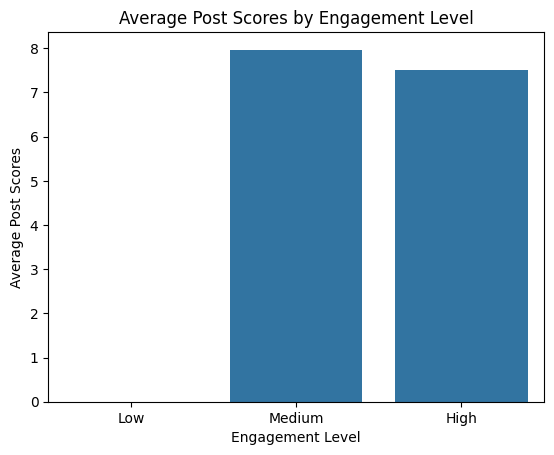

In [65]:
pre_post_df['engagement_level'] = pd.cut(pre_post_df['class_engage'], bins=[1, 2, 3, 4], labels=['Low', 'Medium', 'High'])
avg_scores_by_engagement = pre_post_df.groupby('engagement_level')['avg_post_all_sub'].mean().reset_index()

sns.barplot(x='engagement_level', y='avg_post_all_sub', data=avg_scores_by_engagement)
plt.title('Average Post Scores by Engagement Level')
plt.xlabel('Engagement Level')
plt.ylabel('Average Post Scores')
plt.show()

In [66]:
math_tests = pre_post_df[['n_math_test1', 'Grade/10.00_math_test2', 'Grade/10.00_math_test3', 'Grade/10.00_math_test6']]
math_tests.rename(columns={'n_math_test1': 'Test_1', 'Grade/10.00_math_test2': 'Test_2','Grade/10.00_math_test3': 'Test_3','Grade/10.00_math_test6': 'Test_4'}, inplace=True)

sci_tests = pre_post_df[['Grade/10.00_sci_test1', 'Grade/10.00_sci_test2', 'Grade/10.00_sci_test3', 'Grade/10.00_sci_test4']]
sci_tests.rename(columns={'Grade/10.00_sci_test1': 'Test_1', 'Grade/10.00_sci_test2': 'Test_2','Grade/10.00_sci_test3': 'Test_3','Grade/10.00_sci_test4': 'Test_4'}, inplace=True)

ss_tests = pre_post_df[['n_ss_test1', 'n_ss_test2', 'n_ss_test3']]
ss_tests.rename(columns={'n_ss_test1': 'Test_1', 'n_ss_test2': 'Test_2','n_ss_test3': 'Test_3'}, inplace=True)

rla_tests = pre_post_df[['Grade/10.00_rla_test1', 'Grade/10.00_rla_test2']]
rla_tests.rename(columns={'Grade/10.00_rla_test1': 'Test_1', 'Grade/10.00_rla_test2': 'Test_2'}, inplace=True)

C:\Users\User\AppData\Local\Temp\ipykernel_18084\789273449.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  math_tests.rename(columns={'n_math_test1': 'Test_1', 'Grade/10.00_math_test2': 'Test_2','Grade/10.00_math_test3': 'Test_3','Grade/10.00_math_test6': 'Test_4'}, inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18084\789273449.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sci_tests.rename(columns={'Grade/10.00_sci_test1': 'Test_1', 'Grade/10.00_sci_test2': 'Test_2','Grade/10.00_sci_test3': 'Test_3','Grade/10.00_sci_test4': 'Test_4'}, inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18084\78

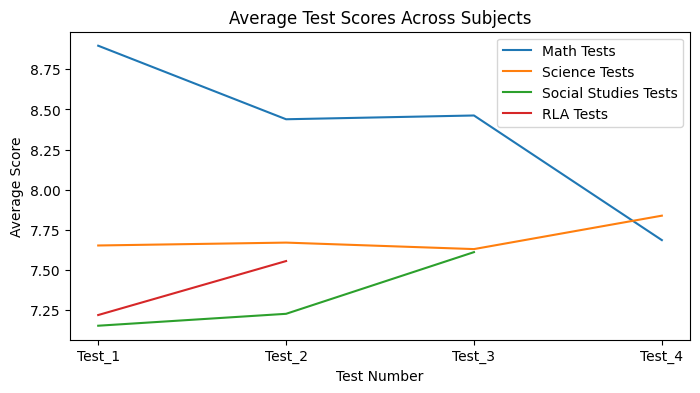

In [67]:
plt.figure(figsize=(8, 4))
# Plot each dataframe with appropriate labels
plt.plot(math_tests.mean(), label='Math Tests')
plt.plot(sci_tests.mean(), label='Science Tests')
plt.plot(ss_tests.mean(), label='Social Studies Tests')
plt.plot(rla_tests.mean(), label='RLA Tests')

plt.xlabel("Test Number")
plt.ylabel("Average Score")
plt.title("Average Test Scores Across Subjects")
plt.legend()
plt.show()

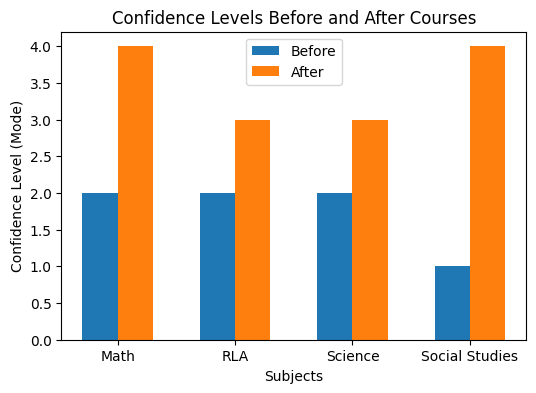

In [68]:
bf_confid_cols = pre_post_df[['confidence_bef_math', 'confidence_bef_rla','confidence_bef_sci', 'confidence_bef_ss']]
af_confid_cols = pre_post_df[['confidence_aft_math', 'confidence_aft_rla','confidence_aft_sci', 'confidence_aft_ss']]
bf_confid_modes = bf_confid_cols.mode().iloc[0]
af_confid_modes = af_confid_cols.mode().iloc[0]

subjects = ['Math', 'RLA', 'Science', 'Social Studies']

X_axis = np.arange(len(subjects))

plt.figure(figsize=(6, 4))
plt.bar(X_axis - 0.15, bf_confid_modes, 0.3, label='Before')
plt.bar(X_axis + 0.15, af_confid_modes, 0.3, label='After')

plt.xticks(X_axis, subjects)
plt.xlabel("Subjects")
plt.ylabel("Confidence Level (Mode)")
plt.title("Confidence Levels Before and After Courses")
plt.legend()
plt.show()

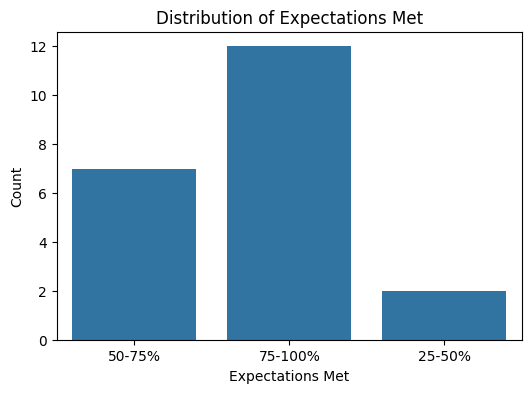

In [69]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Expectations_Met', data=pre_post_df)
plt.title('Distribution of Expectations Met')
plt.xlabel('Expectations Met')
plt.ylabel('Count')
plt.show()

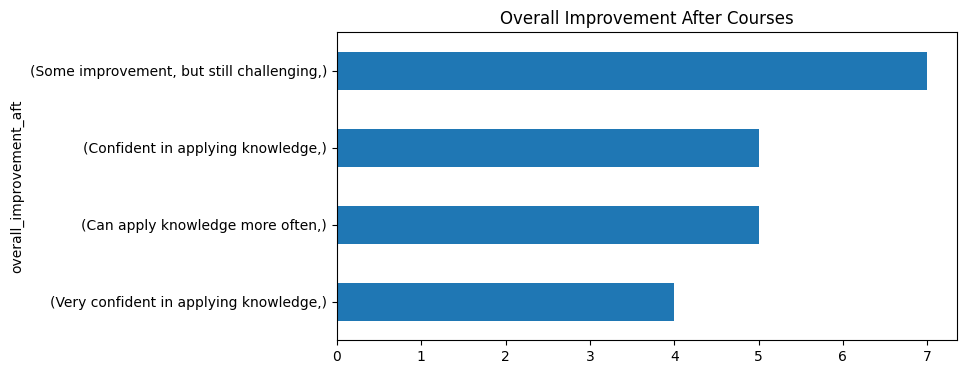

In [70]:
pre_post_df[['overall_improvement_aft']].value_counts().sort_values().plot(kind='barh', figsize=(8, 4))
plt.title('Overall Improvement After Courses')
plt.show()

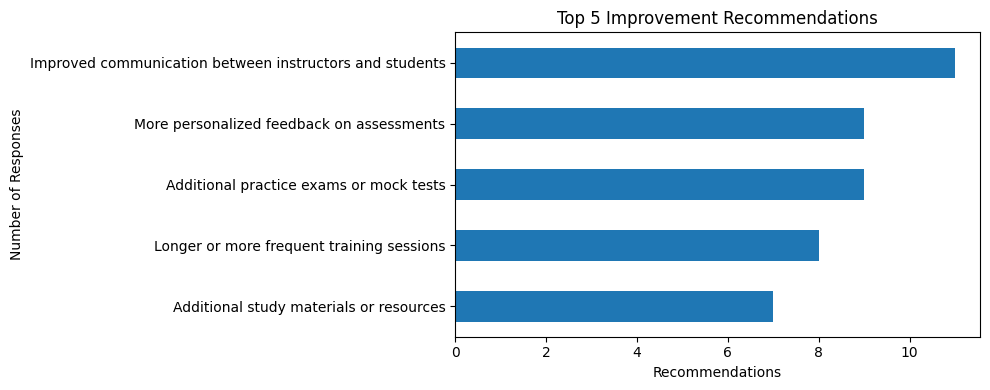

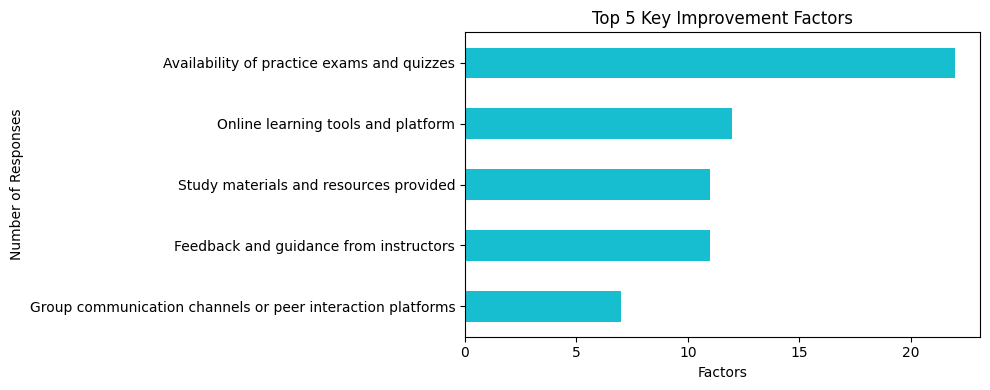

In [71]:
# Preprocess and explode the improvement recommendations
improvement_recommendations_exploded = pj2_survey_df['improvement_recommendations'].str.split(', ').explode()
key_improvement_factors_exploded = pj2_survey_df['key_improvement_factors'].str.split(', ').explode()

 #Count occurrences
recommendation_counts = improvement_recommendations_exploded.value_counts().sort_values().head()
factor_counts = key_improvement_factors_exploded.value_counts().sort_values().head()

# Plotting Improvement Recommendations
plt.figure(figsize=(10, 4))
recommendation_counts.plot(kind='barh')
plt.title('Top 5 Improvement Recommendations')
plt.xlabel('Recommendations')
plt.ylabel('Number of Responses')
# plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plotting Key Improvement Factors
plt.figure(figsize=(10, 4))
factor_counts.plot(kind='barh', color='#17becf')
plt.title('Top 5 Key Improvement Factors')
plt.xlabel('Factors')
plt.ylabel('Number of Responses')
# plt.xticks(rotation=45)
plt.tight_layout()
plt.show()